In [1]:
import os, sys
from pathlib import Path

nb_dir = Path.cwd()
repo_root = nb_dir.parent
sys.path.insert(0, str(repo_root))

print("Notebook dir:", nb_dir)
print("Repo root:", repo_root)

Notebook dir: h:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\notebooks
Repo root: h:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.geo_constraints import DataPaths, build_constraints, save_constraints_npz, read_segy_cube, read_segy_grid

DATA_ROOT = r"H:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\data"
paths = DataPaths(DATA_ROOT)

print("Seis:", paths.segy_seis)
print("AI:", paths.segy_ai)
print("Horizon:", paths.seismic_horizon_dir)
print("Wellheads:", paths.wellheads_csv)
print("Zonation:", paths.zonation_txt)
print("Processed:", paths.processed_dir)

Seis: H:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\data\ATTR_TIME_SGY\synthetic_poststack_TIME_dt1ms_40Hz_fromAI_XY25.sgy
AI: H:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\data\ATTR_TIME_SGY\Acoustic_Impedance_TIME_dt1ms_XY25.sgy
Horizon: H:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\data\seismic_horizon
Wellheads: H:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\data\virtual_wells_regular\virtual_wellheads.csv
Zonation: H:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\data\virtual_wells_zonation\zonation.txt
Processed: H:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\data\processed


In [3]:
grid = read_segy_grid(paths.segy_seis)
seis = read_segy_cube(paths.segy_seis)  # [IL,XL,T]

print("Cube shape [IL,XL,T] =", seis.shape)
print("TWT(ms) head:", grid.twt_ms[:10])
print("TWT(ms) tail:", grid.twt_ms[-10:])
print("dt(ms) =", grid.dt_ms)
print("IL:", grid.ilines[0], "->", grid.ilines[-1], "n=", len(grid.ilines))
print("XL:", grid.xlines[0], "->", grid.xlines[-1], "n=", len(grid.xlines))

Cube shape [IL,XL,T] = (150, 200, 200)
TWT(ms) head: [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
TWT(ms) tail: [190. 191. 192. 193. 194. 195. 196. 197. 198. 199.]
dt(ms) = 1.0
IL: 1 -> 150 n= 150
XL: 1 -> 200 n= 200


In [4]:
from src.geo_constraints import build_constraints, save_constraints_npz

pack = build_constraints(
    paths,
    sigma_trend=3.0,     # 顶界面趋势平滑尺度（先用默认）
    sigma_xy_m=500.0,    # 横向井控影响半径（m）
    sigma_t_ms=15.0      # 纵向井控影响半径（ms）
)

out_npz = os.path.join(paths.processed_dir, "constraints.npz")
save_constraints_npz(out_npz, pack)

print("Saved:", out_npz)
print("P:", pack["P"].shape, pack["P"].dtype)  # [4,IL,XL,T]
print("C:", pack["C"].shape, pack["C"].dtype)  # [IL,XL,T]
print("M:", pack["M"].shape, pack["M"].dtype)  # [IL,XL,T]
print("top2d:", pack["top2d_ms"].shape, "bot2d:", pack["bot2d_ms"].shape)

Saved: H:\GK-MRL-PhysicsConsistent-Inversion\GK-MRL-PhysicsConsistent-Inversion\data\processed\constraints.npz
P: (4, 150, 200, 200) float32
C: (150, 200, 200) float32
M: (150, 200, 200) uint8
top2d: (150, 200) bot2d: (150, 200)


In [5]:
# mask 是否只在 Layer_1–Layer_4 内为 1

i = pack["P"].shape[1] // 2  # middle inline

top = pack["top2d_ms"][i]   # [XL]
bot = pack["bot2d_ms"][i]   # [XL]
M   = pack["M"][i]          # [XL,T]

# 找到每个 xline 上 mask=1 的第一个/最后一个时间样本
t = pack["twt_ms"]
t_first = np.full((M.shape[0],), np.nan, dtype=np.float32)
t_last  = np.full((M.shape[0],), np.nan, dtype=np.float32)

for j in range(M.shape[0]):
    idx = np.where(M[j] == 1)[0]
    if len(idx) > 0:
        t_first[j] = t[idx[0]]
        t_last[j]  = t[idx[-1]]

print("Inline:", i)
print("Mean |t_first - top|:", np.nanmean(np.abs(t_first - top)))
print("Mean |t_last  - bot|:", np.nanmean(np.abs(t_last  - bot)))

Inline: 75
Mean |t_first - top|: 0.0
Mean |t_last  - bot|: 0.0


In [6]:
# zeta 是否在 [0,1] 且随时间递增（层序坐标）

zeta = pack["P"][0, i]  # [XL,T]
print("zeta min/max:", float(zeta.min()), float(zeta.max()))

zeta min/max: 0.0 1.0


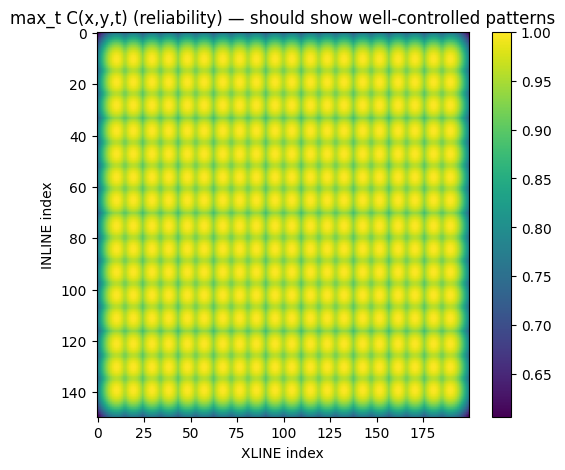

In [7]:
import matplotlib.pyplot as plt

Cmax = pack["C"].max(axis=2)  # [IL,XL]

plt.figure(figsize=(6,5))
plt.imshow(Cmax, aspect="auto")
plt.title("max_t C(x,y,t) (reliability) — should show well-controlled patterns")
plt.xlabel("XLINE index"); plt.ylabel("INLINE index")
plt.colorbar()
plt.show()

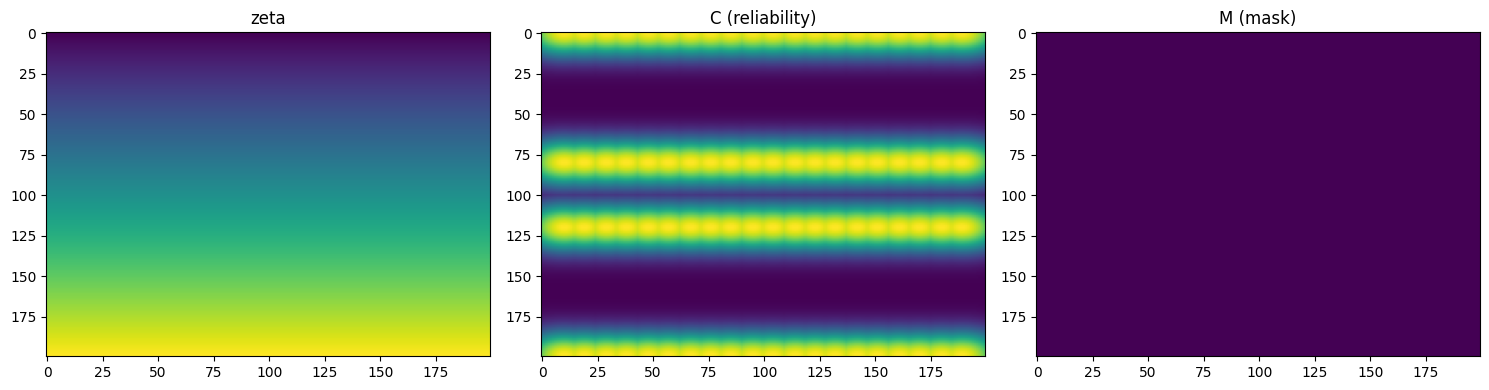

In [8]:
zeta = pack["P"][0, i]  # [XL,T]
C    = pack["C"][i]
M    = pack["M"][i]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(zeta.T, aspect="auto"); axes[0].set_title("zeta")
axes[1].imshow(C.T, aspect="auto");    axes[1].set_title("C (reliability)")
axes[2].imshow(M.T, aspect="auto");    axes[2].set_title("M (mask)")
plt.tight_layout(); plt.show()